In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import copy
import geopandas as gpd
import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt

In [2]:
states = pd.read_excel("./messy_data/states.xlsx")
states.drop(states.index[states.Abbreviation == "DC"], inplace=True)
states.columns = ["Jurisdiction", "Jurisdiction Abbreviation"]
states = states.append({"Jurisdiction" : "Federal", "Jurisdiction Abbreviation" : "FED"}, ignore_index=True)

In [3]:
malePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Male", header=9, nrows=54).dropna(1, "all").dropna(0)
femalePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Female", header=9, nrows=54).dropna(1, "all").dropna(0)
totalPrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Total", header=9, nrows=54).dropna(1, "all").dropna(0)

In [5]:
def cleanAndMeltPopulationTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)

    table = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = "Population")
    table.Year = table.Year.astype(int)
    
    table = states.merge(table, on="Jurisdiction")
    
    return table

In [6]:
meltedMalePrisonerPopulation = cleanAndMeltPopulationTable(malePrisonerPopulation, states)
meltedFemalePrisonerPopulation = cleanAndMeltPopulationTable(femalePrisonerPopulation, states)
meltedTotalPrisonerPopulation = cleanAndMeltPopulationTable(totalPrisonerPopulation, states)

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [7]:
regions = pd.read_excel("./messy_data/state_region.xlsx")
regions.drop(regions.index[regions.State == "District of Columbia"], inplace=True)

In [8]:
def aggregateRegionalPopulationSum(table, regions):
    
    table = regions.merge(table, left_on="State", right_on="Jurisdiction", how="right")
    temp_index = table["Jurisdiction"] == "Federal"
    table.loc[temp_index, "Region"] = "Federal"
    table.loc[temp_index, "Division"] = "Federal"
    
    regionSum = table.groupby(["Year", "Region"]).Population.sum()
    divisionSum = table.groupby(["Year", "Region", "Division"]).Population.sum()
    
    return regionSum, divisionSum

In [9]:
malePrisonerPopulationRegionSum, malePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedMalePrisonerPopulation, regions)
femalePrisonerPopulationRegionSum, femalePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedFemalePrisonerPopulation, regions)
totalPrisonerPopulationRegionSum, totalPrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedTotalPrisonerPopulation, regions)

In [10]:
def plotStatePopulationMap(table, gender, selectedYears):
    
    table = table[table.Jurisdiction != "Federal"]

    cmax = table.Population.max()
    cmin = table.Population.min()
    
    years = table.Year.unique()
    heatMapData = [{"type" : "choropleth",  "locations" : table.loc[table.Year == year, "Jurisdiction Abbreviation"], "locationmode" : "USA-states", "colorscale" : "Viridis", "zmin" : cmin, "zmax" : cmax, "z" : table.Population[table.Year == year].astype(float)} for year in years]
    mapLayout = [{"geo" : {"scope" : 'usa'}, "title" : gender + " Prisoner Population by State, " + str(year)} for year in years]
    
    for i, data in enumerate(heatMapData):
        if years[i] in selectedYears:
            usHeatMap = go.Figure(data=[data], layout=mapLayout[i])
            iplot(usHeatMap)

In [11]:
init_notebook_mode()

In [12]:
plotStatePopulationMap(meltedMalePrisonerPopulation, "Male", [1978, 2016])

In [13]:
plotStatePopulationMap(meltedFemalePrisonerPopulation, "Female", [1978, 2016])

In [14]:
plotStatePopulationMap(meltedTotalPrisonerPopulation, "Total", [1978, 2016])

In [15]:
usMap = gpd.read_file("./us_states_map.json")
usMap = usMap.loc[list(map(lambda x: x not in ["Puerto Rico", "District of Columbia"], usMap.NAME))]
usMap = usMap.merge(states, left_on="NAME", right_on = "Jurisdiction", how="left").drop("Jurisdiction", axis=1)
usMap.columns = ["GEO_ID", "STATE", "NAME", "LSAD", "CENSUSAREA", "geometry", "Abbreviatio"]
usMap = usMap.merge(regions, left_on="NAME", right_on = "State", how="left").drop("State", axis=1)

In [16]:
def plotGeoPandasUSMap(usMap, title=None, dataColumn=None, dataLimit=(None, None)):
    
    fig, mapAx = plt.subplots(1, 1)
    
    mapLimitW, mapLimitE, mapLimitS, mapLimitN = -185, -65, 15, 75
    mapAx.axis((mapLimitW, mapLimitE, mapLimitS, mapLimitN))
    mapAx.axis('off')
    mapAx.set_aspect('equal', 'box')
    mapAx.set_title(title)
    
    usMap.plot(column=dataColumn, figsize=(20, 20), edgecolor="k", ax=mapAx, legend=True, vmin=dataLimit[0], vmax=dataLimit[1])

In [21]:
def plotRegionalPopulation(table, usMap, gender, selectedYears):
    
    regionType = table.index.names[1]

    tableWOFederal = table[table.index.get_level_values(1) != "Federal"]

    years = table.index.get_level_values(0).unique()
    dividedTableWOFederal = [tableWOFederal[year] for year in years]

    usRegionMap = usMap[[regionType, "geometry"]].dissolve(regionType)

    colorlimit = (tableWOFederal.min(), tableWOFederal.max())
    for i, oneYearTable in enumerate(dividedTableWOFederal):
        year = years[i]
        if year in selectedYears:

            oneYearTable = usRegionMap.join(oneYearTable)

            figtitle = gender + " Prisoner Population by " + regionType + ", " + str(year)
            plotGeoPandasUSMap(oneYearTable, figtitle, "Population", colorlimit)


    figtitle = gender + " Prisoner Population by " + regionType
    ax = table.unstack().plot(title = figtitle)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis = "y", length=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(table.index.get_level_values(1).unique()))

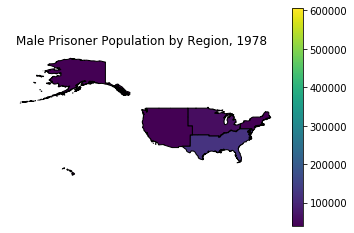

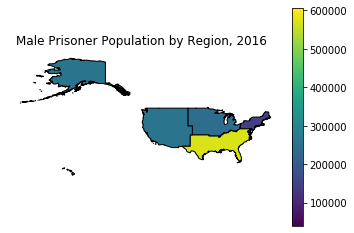

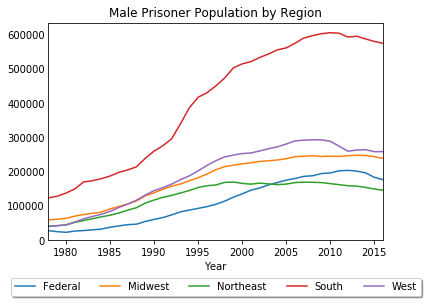

In [22]:
plotRegionalPopulation(malePrisonerPopulationRegionSum, usMap, "Male", [1978, 2016])

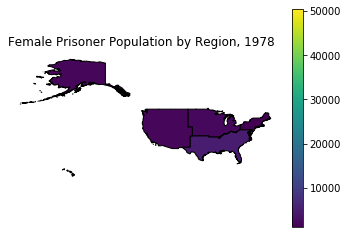

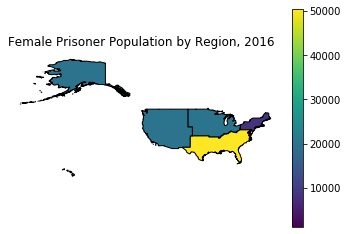

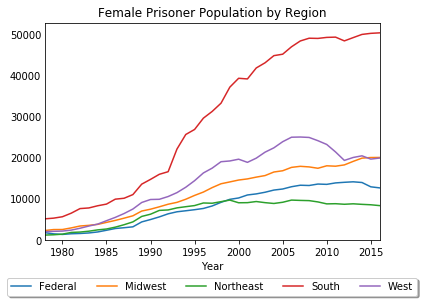

In [23]:
plotRegionalPopulation(femalePrisonerPopulationRegionSum, usMap, "Female", [1978, 2016])

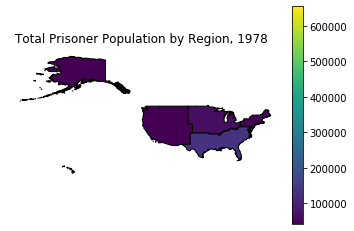

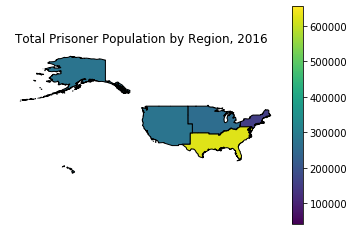

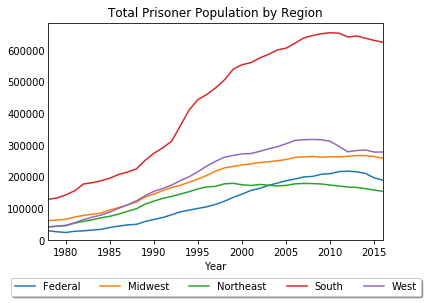

In [24]:
plotRegionalPopulation(totalPrisonerPopulationRegionSum, usMap, "Total", [1978, 2016])

In [25]:
def dropRegionIndex(table):
    table = copy.deepcopy(table)
    
    table.index = table.index.droplevel(1)
    return table

In [119]:
def plotDivisionalPopulation(divisionTable,stateTable, regionTable, usMap, gender, selectedYears):
    
    regionType = divisionTable.index.names[1]

    divisionTableWOFederal = divisionTable[divisionTable.index.get_level_values(1) != "Federal"]

    years = divisionTable.index.get_level_values(0).unique()
    dividedTableWOFederal = [divisionTableWOFederal[year] for year in years]

    usRegionMap = usMap[[regionType, "geometry"]].dissolve(regionType)

    colorlimit = (divisionTableWOFederal.min(), divisionTableWOFederal.max())
    for i, oneYearTable in enumerate(dividedTableWOFederal):
        year = years[i]
        if year in selectedYears:

            oneYearTable = usRegionMap.join(oneYearTable)

            figtitle = gender + " Prisoner Population by " + regionType + ", " + str(year)
            plotGeoPandasUSMap(oneYearTable, figtitle, "Population", colorlimit)


    figtitle = gender + " Prisoner Population by " + regionType
    ax = divisionTableWOFederal.unstack().plot(title = figtitle)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis = "y", length=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(divisionTableWOFederal.index.get_level_values(1).unique()))
    
    stateTableWOFederal = stateTable[stateTable.Jurisdiction != "Federal"]
    stateTableWOFederal = stateTableWOFederal.pivot(values='Population', index="Year", columns="Jurisdiction")
    regionTable = regionTable.sort_values(by="State")
    stateTableWOFederal.columns = pd.MultiIndex.from_tuples(zip(regionTable["Division"], regionTable["State"]))
    
    divisions = stateTableWOFederal.columns.levels[0]
    axes = [None for i in range(len(divisions))]
    for i, division in enumerate(divisions):
                                
        tableOneDivision = stateTableWOFederal[division]
        
        figtitle = gender + " Prisoner Population, " + str(division)
    
        axes[i] = tableOneDivision.plot(title = figtitle)
        axes[i].set_ylim(bottom=0)
        axes[i].tick_params(axis = "y", length=0)
        axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(tableOneDivision.index.unique()))

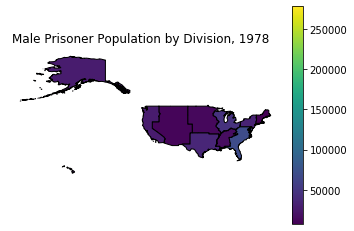

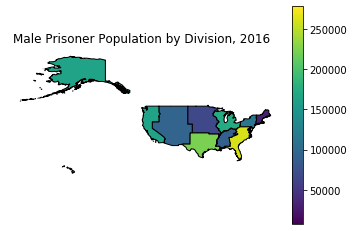

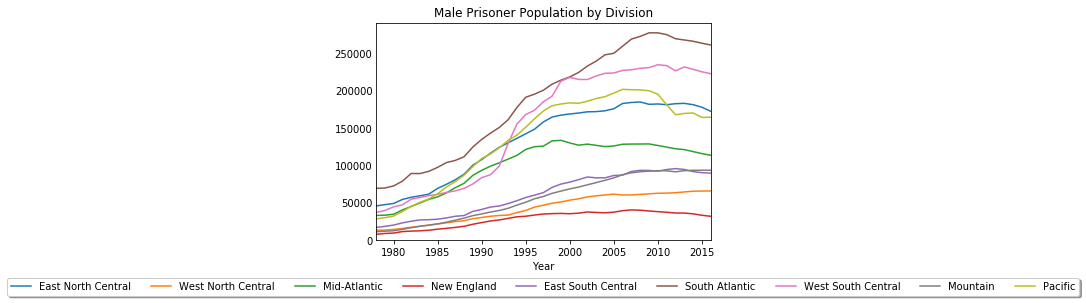

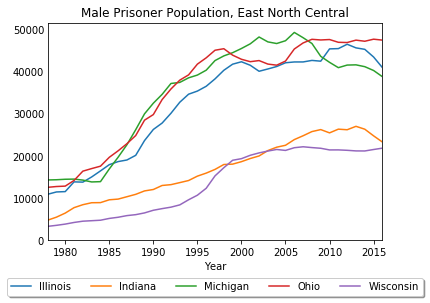

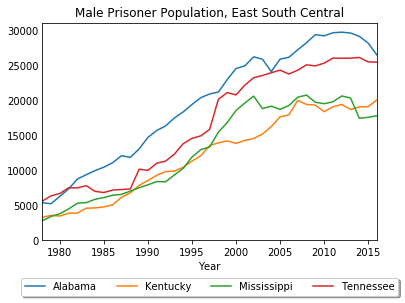

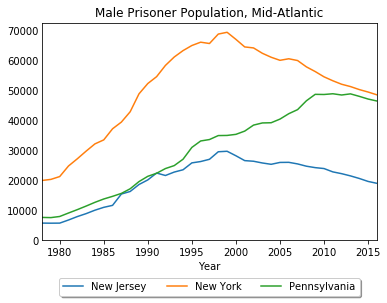

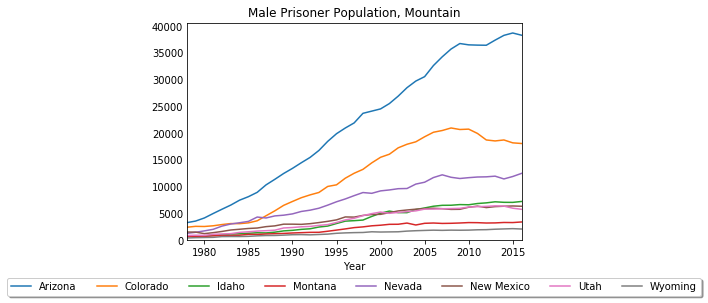

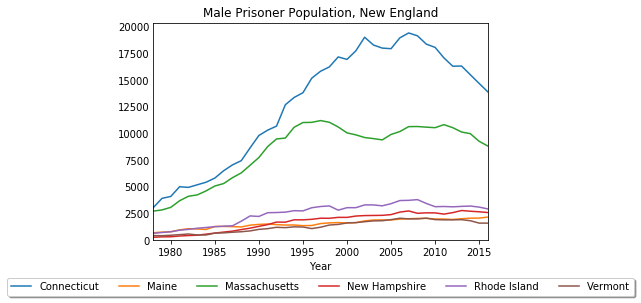

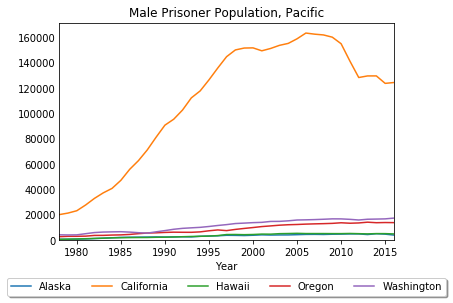

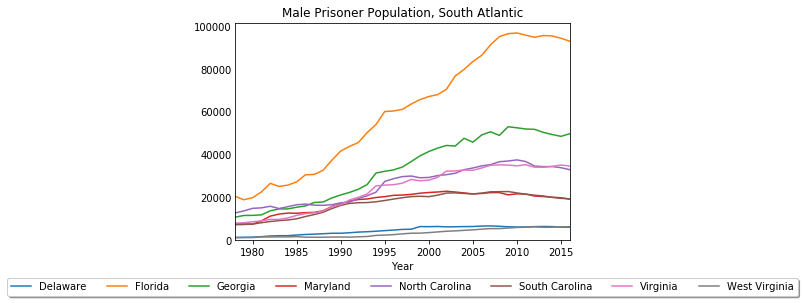

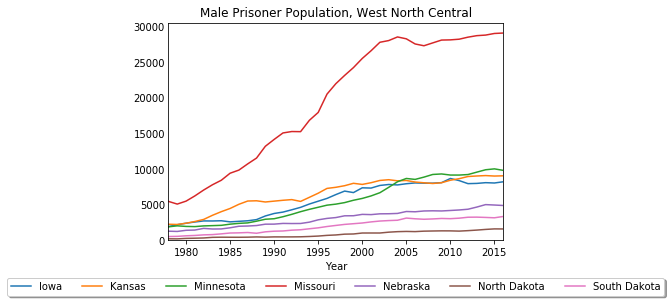

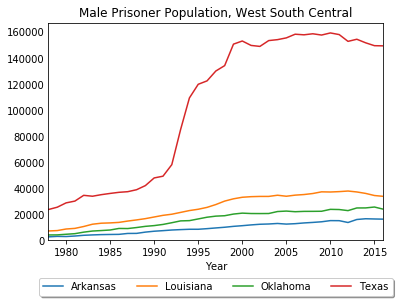

In [120]:
plotDivisionalPopulation(dropRegionIndex(malePrisonerPopulationDivisionSum),meltedMalePrisonerPopulation, regions, usMap, "Male", [1978, 2016])

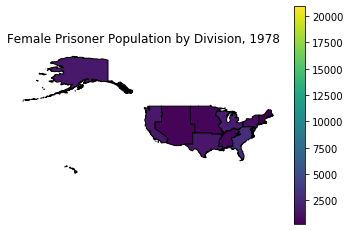

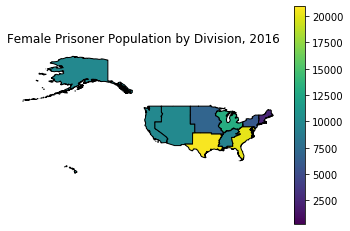

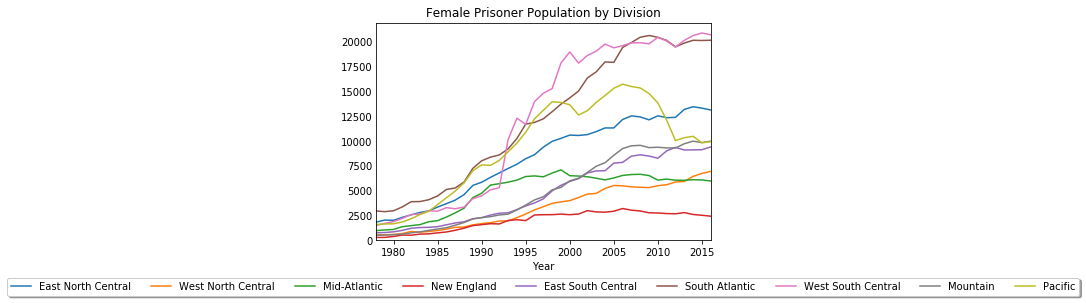

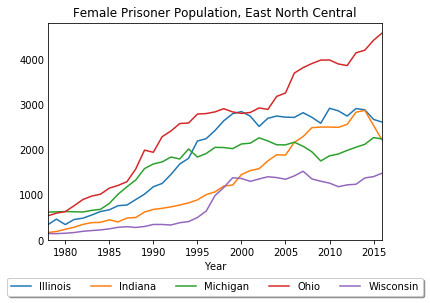

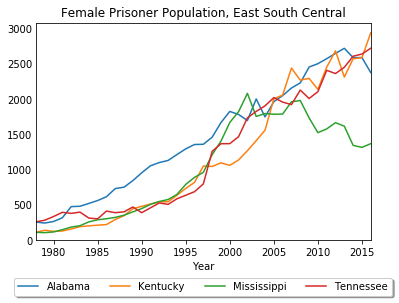

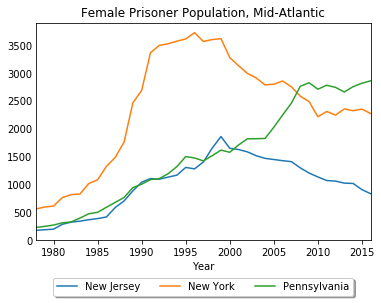

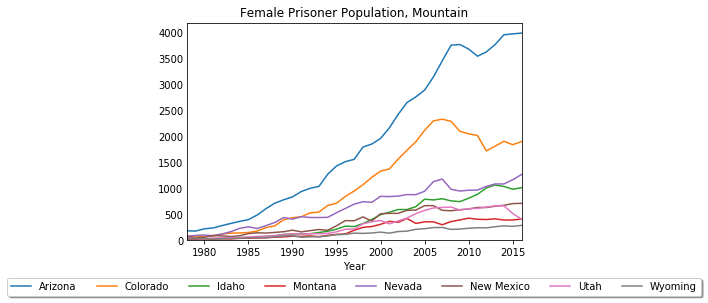

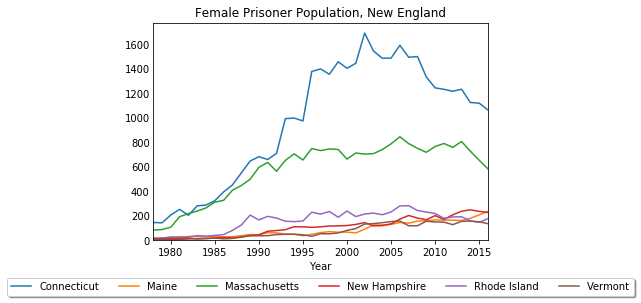

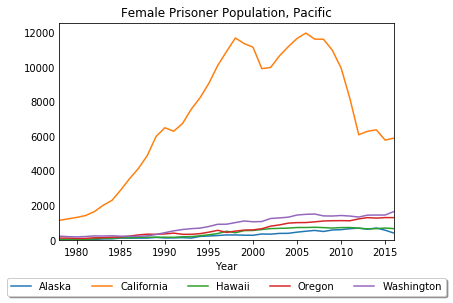

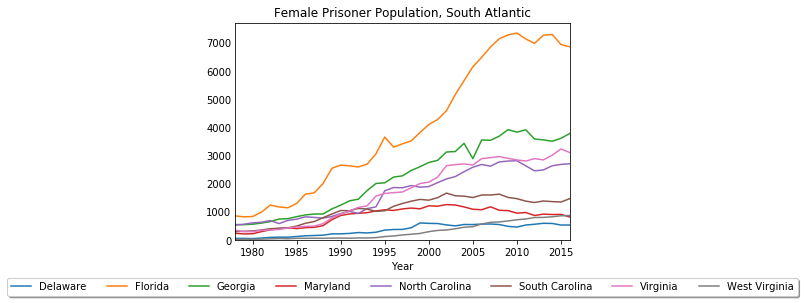

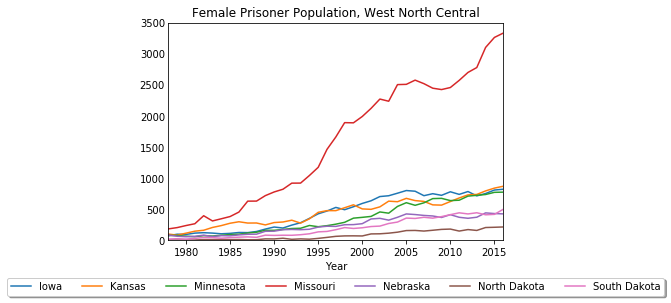

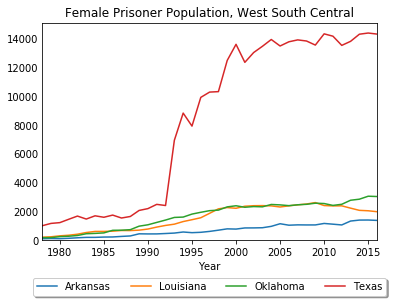

In [121]:
plotDivisionalPopulation(dropRegionIndex(femalePrisonerPopulationDivisionSum),meltedFemalePrisonerPopulation, regions, usMap, "Female", [1978, 2016])

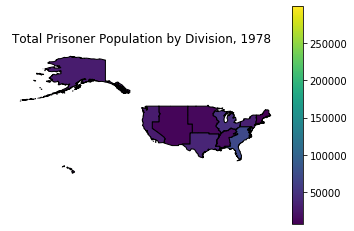

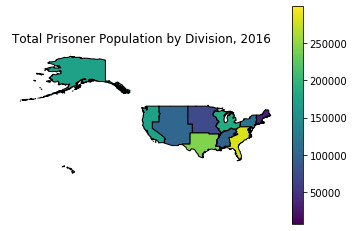

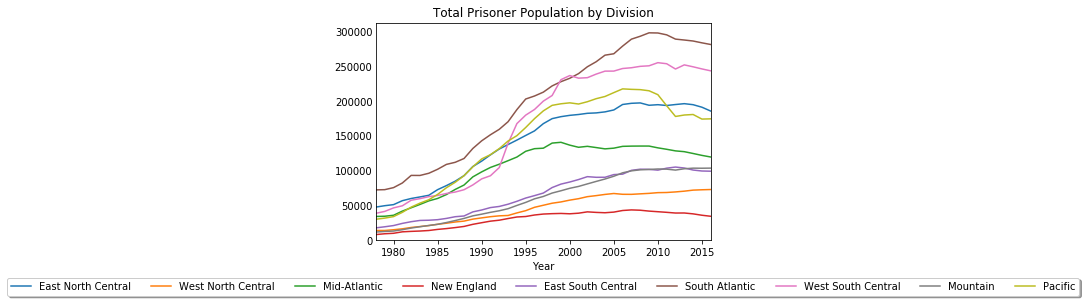

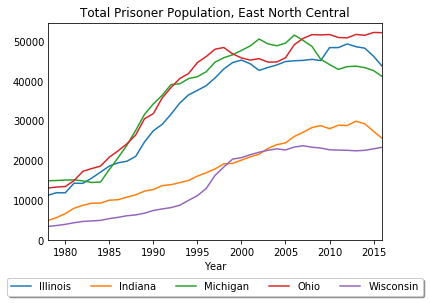

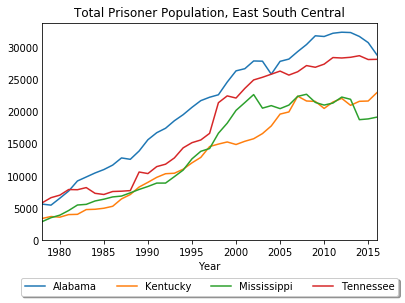

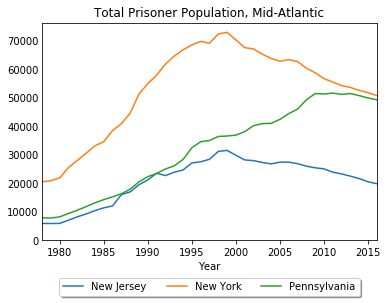

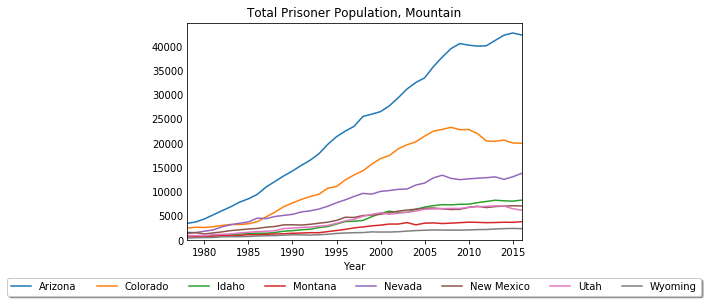

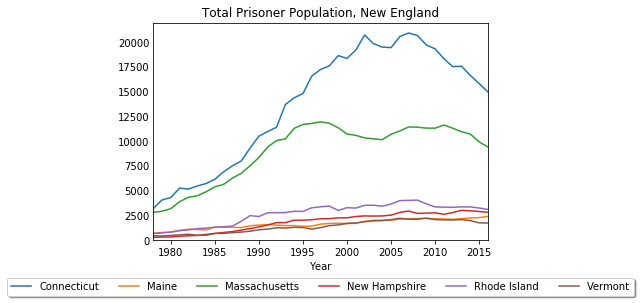

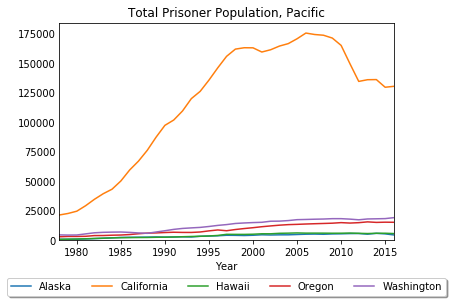

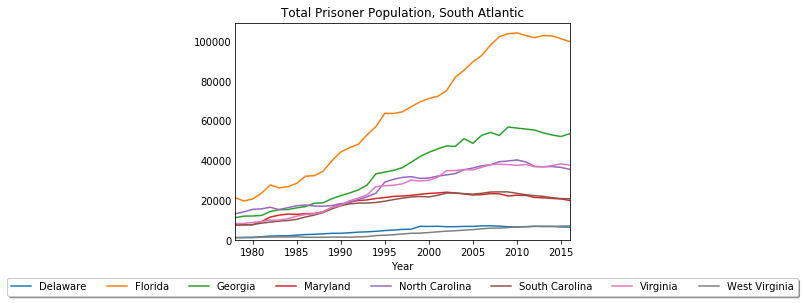

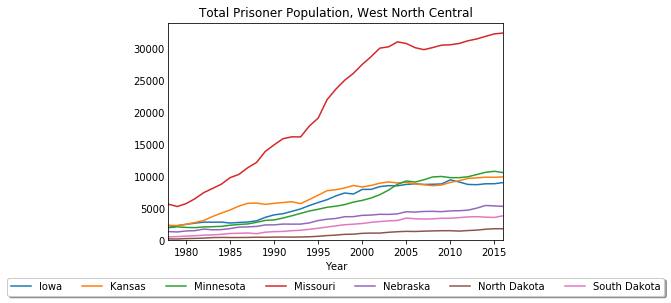

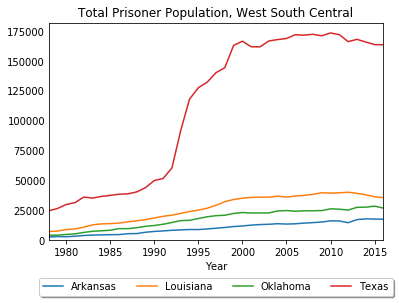

In [122]:
plotDivisionalPopulation(dropRegionIndex(totalPrisonerPopulationDivisionSum),meltedTotalPrisonerPopulation, regions, usMap, "Total", [1978, 2016])

In [124]:
def cleanAndMeltCustodyOccupancyTable(table, states, tableType):
    
    table = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = tableType)
    if tableType == "Occupancy":
        table.Occupancy = table.Occupancy / 100
    
    table.Year = table.Year.astype(int)
    table = states.merge(table, on="Jurisdiction")
    
    return table

In [125]:
custodyPopulation_11_16 = pd.read_excel("./messy_data/Prison occupation rate.xlsx", "Custody Population", na_values="/")
occupancyLowRate_11_16 = pd.read_excel("./messy_data/Prison occupation rate.xlsx", "Highest Capacity", na_values="/")
occupancyHighRate_11_16 = pd.read_excel("./messy_data/Prison occupation rate.xlsx", "Lowest Capacity", na_values="/")

In [126]:
def plotAnnualStateOccupancy(table, low_or_high, selectedYears):
    
    table = table[table.Occupancy != "Federal"]

    cmax = table.Occupancy.max()
    cmin = table.Occupancy.min()
    
    years = table.Year.unique()

    heatMapData = [{"type" : "choropleth",  "locations" : table.loc[table.Year == year, "Jurisdiction Abbreviation"], "locationmode" : "USA-states", "colorscale" : "Viridis", "zmin" : cmin, "zmax" : cmax, "z" : table.Occupancy[table.Year == year].astype(float)} for year in years]
    mapLayout = [{"geo" : {"scope" : 'usa'}, "title" : "Prison Occupancy (" + low_or_high + " Estimation) by State, " + str(year)} for year in years]
    
    for i, data in enumerate(heatMapData):
        
        year = years[i]
        
        if year in selectedYears:
        
            usHeatMap = go.Figure(data=[data], layout=mapLayout[i])
            iplot(usHeatMap)
            

In [128]:
meltedCustodyPopulation_11_16 = cleanAndMeltCustodyOccupancyTable(custodyPopulation_11_16, states, "Population")
meltedOccupancyLowRate_11_16 = cleanAndMeltCustodyOccupancyTable(occupancyLowRate_11_16, states, "Occupancy")
meltedOccupancyHighRate_11_16 = cleanAndMeltCustodyOccupancyTable(occupancyHighRate_11_16, states, "Occupancy")

In [129]:
plotAnnualStateOccupancy(meltedOccupancyHighRate_11_16, "High", [2011, 2016])

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [135]:
plotAnnualStateOccupancy(meltedOccupancyLowRate_11_16, "Low", [2011, 2016])

In [131]:
def aggregateRegionalOccupancy(table, populationTable, regions):
    
    table = regions.merge(table.dropna(), left_on="State", right_on="Jurisdiction", how="right")
    table = table.merge(populationTable[["Jurisdiction", "Year", "Population"]].dropna(), on=["Jurisdiction", "Year"], how="left")

    temp_index = table["Jurisdiction"] == "Federal"
    table.loc[temp_index, "Region"] = "Federal"
    table.loc[temp_index, "Division"] = "Federal"
    table["Capacity"] = table.Population / table.Occupancy
    
    regionCapacity = table.groupby(["Year", "Region"]).Capacity.sum()
    divisionCapacity = table.groupby(["Year", "Region", "Division"]).Capacity.sum()
    
    regionPopulation = table.groupby(["Year", "Region"]).Population.sum()
    divisionPopulation = table.groupby(["Year", "Region", "Division"]).Population.sum()
    
    regionOccupancy = (regionPopulation / regionCapacity).rename("Occupancy")
    divisionOccupancy = (divisionPopulation / divisionCapacity).rename("Occupancy")
    
    return regionOccupancy, divisionOccupancy

In [132]:
regionLowOccupancy, divisionLowOccupancy = aggregateRegionalOccupancy(meltedOccupancyLowRate_11_16, meltedCustodyPopulation_11_16, regions)
regionHighOccupancy, divisionHighOccupancy = aggregateRegionalOccupancy(meltedOccupancyHighRate_11_16, meltedCustodyPopulation_11_16, regions)

In [134]:
def plotRegionalOccupancy(table, usMap, low_or_high, selectedYears):
    
    regionType = table.index.names[1]

    tableWOFederal = table[table.index.get_level_values(1) != "Federal"]

    years = table.index.get_level_values(0).unique()
    dividedTableWOFederal = [tableWOFederal[year] for year in years]

    usRegionMap = usMap[[regionType, "geometry"]].dissolve(regionType)

    colorlimit = (tableWOFederal.min(), tableWOFederal.max())
    for i, oneYearTable in enumerate(dividedTableWOFederal):
        year = years[i]
        
        if year in selectedYears:
            oneYearTable = usRegionMap.join(oneYearTable)

            figtitle = "Prison Occupancy (" + low_or_high + " Estimate) by " + regionType + ", " + str(year)
            plotGeoPandasUSMap(oneYearTable, figtitle, "Occupancy", colorlimit)


    figtitle = "Prison Occupancy (" + low_or_high + " Estimate) by " + regionType
    ax = table.unstack().plot(title = figtitle)
    ax.tick_params(axis = "y", length=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(table.index.get_level_values(1).unique()))

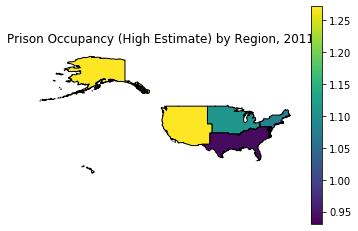

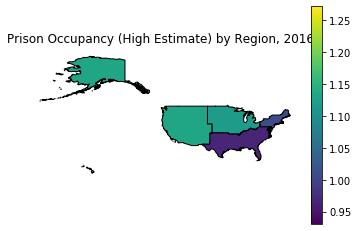

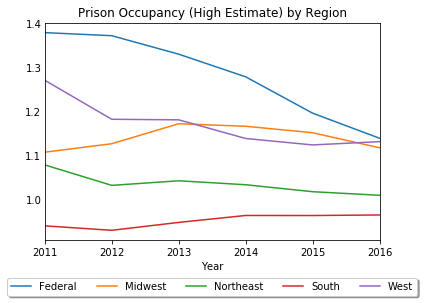

In [137]:
plotRegionalOccupancy(regionHighOccupancy, usMap, "High", [2011, 2016])

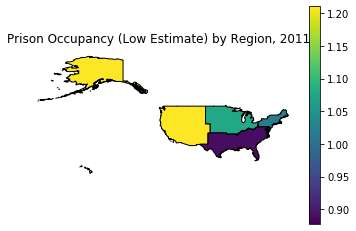

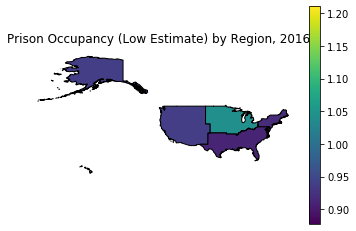

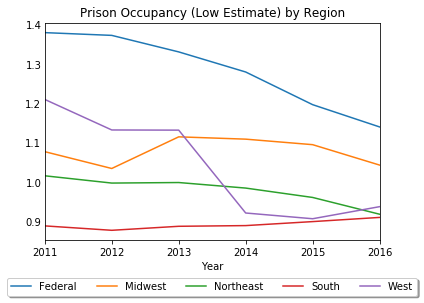

In [138]:
plotRegionalOccupancy(regionLowOccupancy, usMap, "Low", [2011, 2016])

In [167]:
def plotDivisionalOccupancy(divisionTable,stateTable, regionTable, usMap, low_or_high, selectedYears):
    
    regionType = divisionTable.index.names[1]

    divisionTableWOFederal = divisionTable[divisionTable.index.get_level_values(1) != "Federal"]

    years = divisionTable.index.get_level_values(0).unique()
    dividedTableWOFederal = [divisionTableWOFederal[year] for year in years]

    usRegionMap = usMap[[regionType, "geometry"]].dissolve(regionType)

    colorlimit = (divisionTableWOFederal.min(), divisionTableWOFederal.max())
    for i, oneYearTable in enumerate(dividedTableWOFederal):
        year = years[i]
        
        if year in selectedYears:
            oneYearTable = usRegionMap.join(oneYearTable)

            figtitle = "Prison Occupancy (" + low_or_high + " Estimate) by " + regionType + ", " + str(year)
            plotGeoPandasUSMap(oneYearTable, figtitle, "Occupancy", colorlimit)


    figtitle = "Prison Occupancy (" + low_or_high + " Estimate) by " + regionType
    ax = divisionTableWOFederal.unstack().plot(title = figtitle)
    ax.tick_params(axis = "y", length=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(divisionTableWOFederal.index.get_level_values(1).unique()))
    
    stateTableWOFederal = stateTable[stateTable.Jurisdiction != "Federal"]
    stateTableWOFederal = stateTableWOFederal.pivot(values='Occupancy', index="Year", columns="Jurisdiction")
    regionTable = regionTable.sort_values(by="State")
    stateTableWOFederal.columns = pd.MultiIndex.from_tuples(zip(regionTable["Division"], regionTable["State"]))
    
    divisions = stateTableWOFederal.columns.levels[0]
    axes = [None for i in range(len(divisions))]
    for i, division in enumerate(divisions):
                                
        tableOneDivision = stateTableWOFederal[division]
        
        figtitle = "Prison Occupancy (" + low_or_high + " Estimate), " + str(division)
    
        axes[i] = tableOneDivision.plot(title = figtitle)
        axes[i].tick_params(axis = "y", length=0)
        axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(tableOneDivision.index.unique()))
    
    

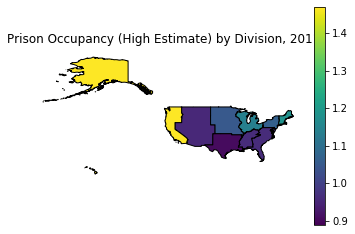

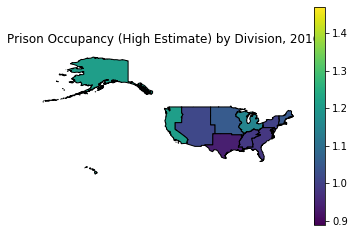

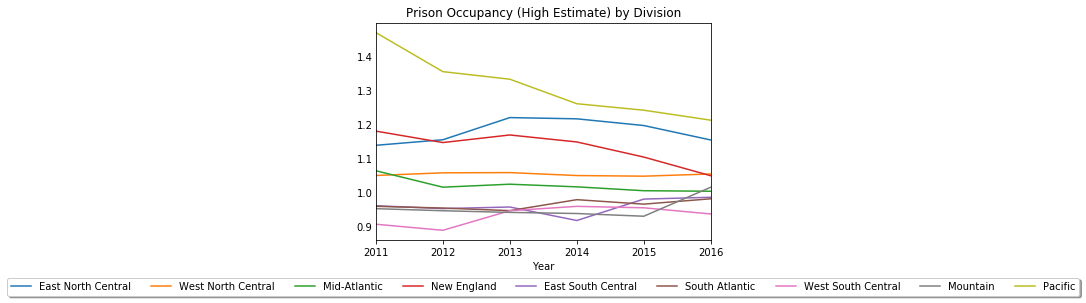

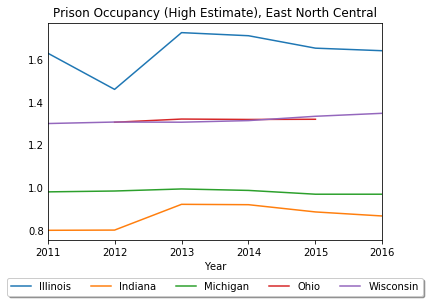

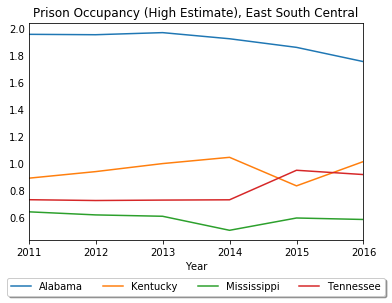

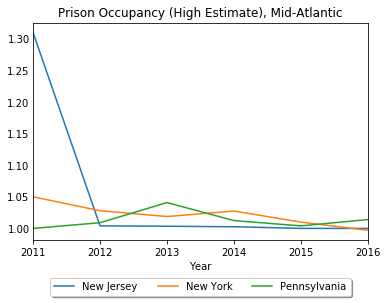

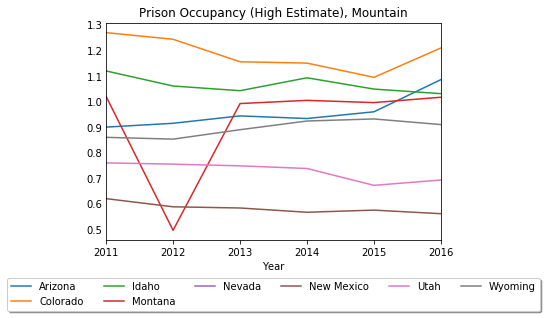

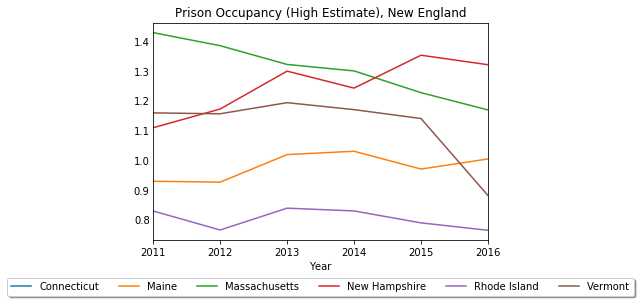

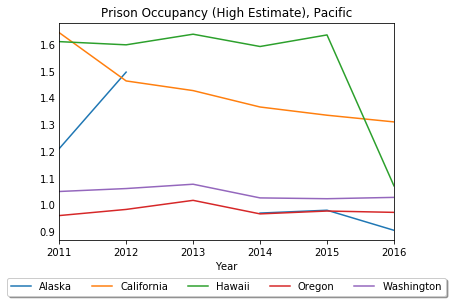

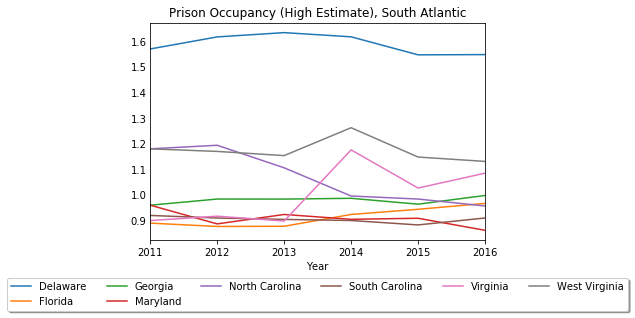

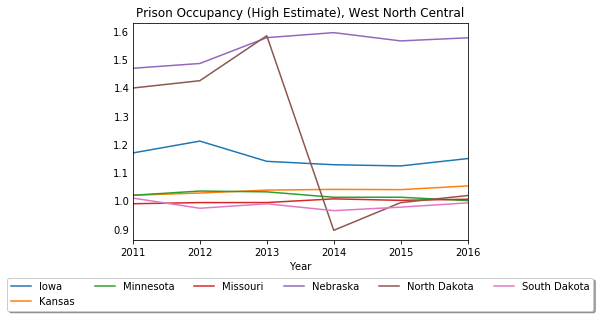

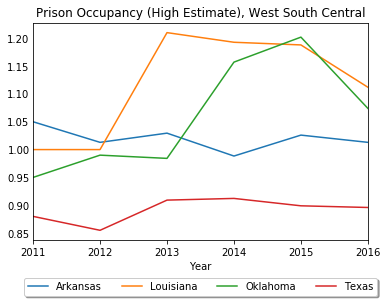

In [169]:
plotDivisionalOccupancy(dropRegionIndex(divisionHighOccupancy),meltedOccupancyHighRate_11_16,regions ,usMap, "High", [2011, 2016])

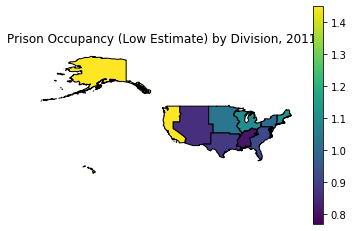

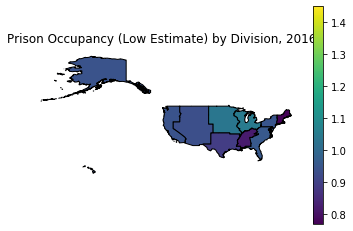

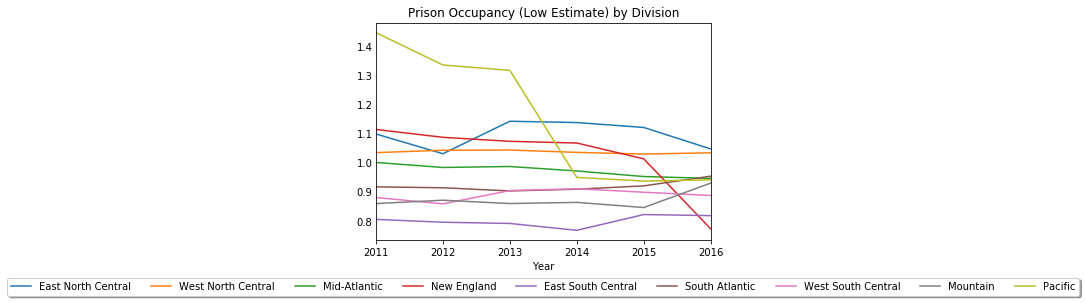

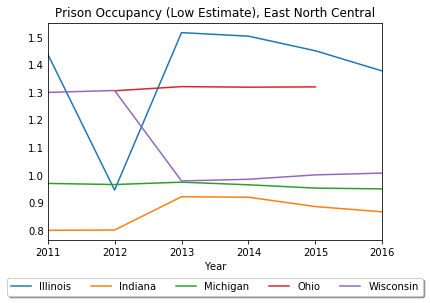

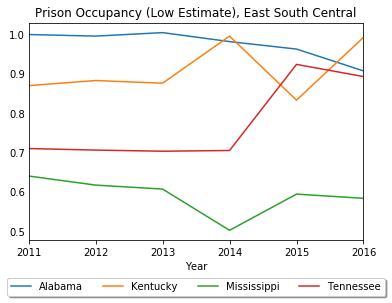

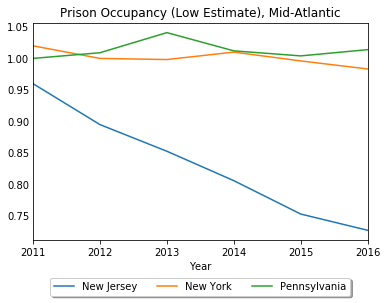

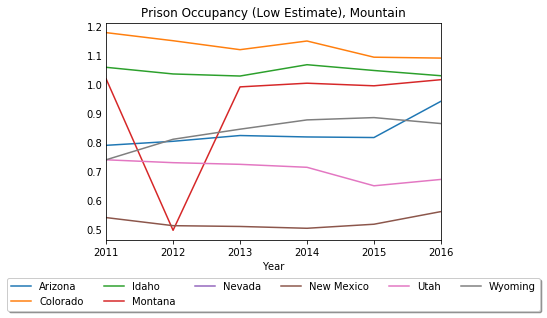

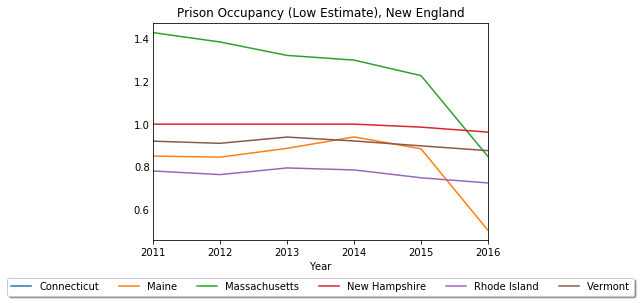

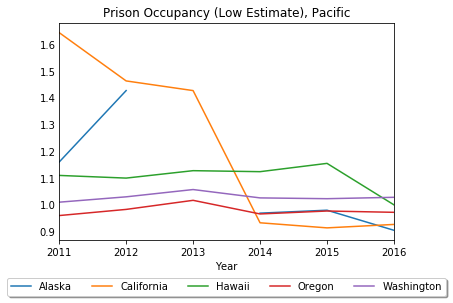

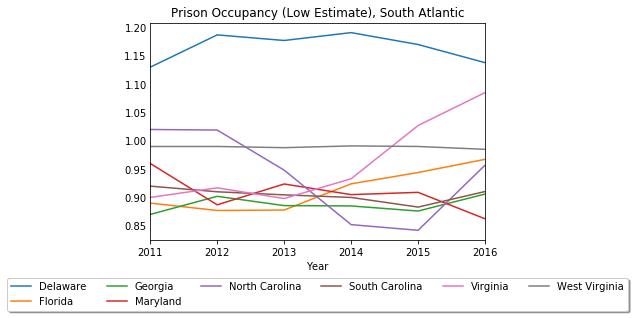

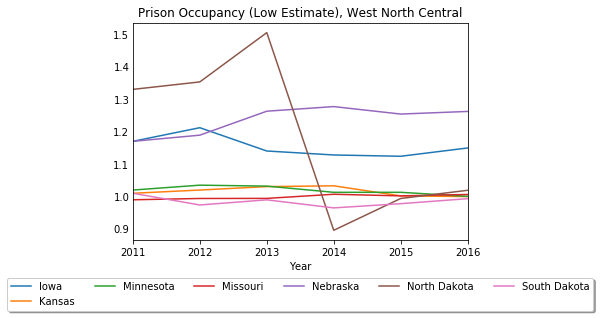

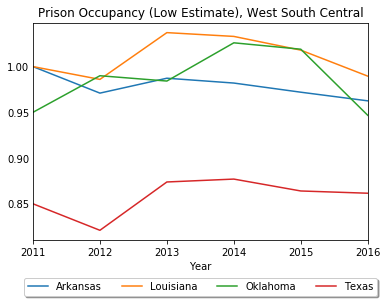

In [170]:
plotDivisionalOccupancy(dropRegionIndex(divisionLowOccupancy),meltedOccupancyLowRate_11_16,regions ,usMap, "Low", [2011, 2016])